In [1]:
from __future__ import print_function
import numpy as np
import os
import time

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
import argparse
from tensorflow.keras.layers import Input
import scipy.misc
import csv

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot
import math

## MODEL

In [6]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [7]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [8]:
model = ResNet50(input_tensor = q_model.input)

In [10]:
model.load_weights("./fp_model_40_resnet50.h5")
q_model.load_weights("./q_model_40_resnet50.h5")

In [11]:
def extract(image):
    image = np.expand_dims(image, axis=0)
    image = tf.convert_to_tensor(image)
    logits_1 = model(image)
    logits_2 = q_model(image)
    predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
    predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
    return logits_1,logits_2,predict_1,predict_2

## IMAGES

In [12]:
def preprocess_image(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

In [13]:
def stats(test_list):
    mean = sum(test_list) / len(test_list)
    variance = sum([((x - mean) ** 2) for x in test_list]) / len(test_list)
    res = variance ** 0.5
    return mean,res

In [14]:
# THIS IS ONLY THE VALIDATION SET OF IMAGES
BATCH_SIZE=50
# data_set, info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
#                                      data_dir='/local/rcs/wei/image_net/')
es = {'file_name': tf.TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(), dtype=tf.int64, name=None)}
mydataset = tf.data.experimental.load("/local/rcs/wei/Avg3ImagePerClass/",es).batch(BATCH_SIZE).prefetch(1)

In [ ]:
# figs = tfds.show_examples(data_set)

In [15]:
len(mydataset)

60

In [17]:
total=0
for i in mydataset:
    images = i['image']
    for image in images:
        total+=1

print(total)

4000


In [22]:
for i, feature in enumerate(mydataset):
    k = feature['image'][49]
    l = feature['label'][49]
    break

In [23]:
l

<tf.Tensor: shape=(), dtype=int64, numpy=17>

In [26]:
a,b,c,d = extract(k)

In [32]:
tf.argmax(a, axis=-1).numpy()

array([17])

## METHODS FOR GENERATING ATTACKS AND MEASURING PERFORMANCE

### 1. A = argmax c*L( q_model(image + A) , sudo_y) - L( orig_model(image + A) , y)

In [18]:
#HYPER PARAMETERS
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [20]:
def first(image,label):
    image = np.expand_dims(image, axis=0)
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])
    
    if orig_label != quant_label:
        return -2,-2,-2,-2,-2
    
    if orig_label != label:
        print(orig_label,label)
        return -3,-3,-3,-3,-3
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
            # increases this loss, c should be large to make this more importatnt
            loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
            # decreases this loss
            final_loss = loss1 - c*loss2
            #change position of the c
            #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
        #grads_value = iterate([image])[0]
        '''
        if transformation == 'light':
            grads = constraint_light(grads)  # constraint the gradients value
        elif transformation == 'occl':
            grads = constraint_occl(grads, start_point,occlusion_size)  # constraint the gradients value
        elif transformation == 'blackout':
            grads = constraint_black(grads)  # constraint the gradients value
        print(grads)
        '''
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        
        if not label1 == label2:
            
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.6:
                
                total_time = time.time() - start_time
                
                gen_img_deprocessed = test_image_deprocess
                orig_img_deprocessed = deprocess_image(orig_img.numpy())
                
                norm = np.max(np.abs(A))
                
                return total_time, norm, iters, gen_img_deprocessed, A
    return -1, -1, -1, -1, -1


In [21]:
def topk(model_pred, qmodel_pred, k):
    preds = tf.keras.applications.resnet.decode_predictions(model_pred.numpy(), top=k)
    qpreds = tf.keras.applications.resnet.decode_predictions(qmodel_pred.numpy(), top=1)[0][0][1]
    
    for pred in preds[0]:
        if pred[1] == qpreds:
            return True
    
    return False

def firstk(image,k):
    image = np.expand_dims(image, axis=0)
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])
    
    if orig_label != quant_label:
        return -2,-2,-2,-2,-2
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
            # increases this loss, c should be large to make this more importatnt
            loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
            # decreases this loss
            final_loss = loss1 - c*loss2
            #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
        #grads_value = iterate([image])[0]
        '''
        if transformation == 'light':
            grads = constraint_light(grads)  # constraint the gradients value
        elif transformation == 'occl':
            grads = constraint_occl(grads, start_point,occlusion_size)  # constraint the gradients value
        elif transformation == 'blackout':
            grads = constraint_black(grads)  # constraint the gradients value
        print(grads)
        '''
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        
        if not topk(pred1, pred2, k):
            
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.6:
        
                total_time = time.time() - start_time
                
                gen_img_deprocessed = test_image_deprocess
                orig_img_deprocessed = deprocess_image(orig_img.numpy())
                
                norm = np.max(np.abs(A))
                
                return total_time, norm, iters, gen_img_deprocessed, A
            
    return -1, -1, -1, -1, -1

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [22]:
c = 1
grad_iterations = 20
transformation = 'light'
step = 1
epsilon = 8

In [23]:
def second(image,label):
    image = np.expand_dims(image, axis=0)
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])
    
    if orig_label != quant_label:
        print(orig_label)
        return -2,-2,-2,-2,-2
    
    if orig_label != label:
        return -3,-3,-3,-3,-3
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = K.mean(model(input_image+A)[..., orig_label])
            loss2 = K.mean(q_model(input_image+A)[..., orig_label])
            final_loss = K.mean(loss1 - c*loss2)


        grads = normalize(g.gradient(final_loss, input_image))
        #grads_value = iterate([image])[0]
        '''
        if transformation == 'light':
            grads = constraint_light(grads)  # constraint the gradients value
        elif transformation == 'occl':
            grads = constraint_occl(grads, start_point,occlusion_size)  # constraint the gradients value
        elif transformation == 'blackout':
            grads = constraint_black(grads)  # constraint the gradients value
        print(grads)
        '''
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        
        if not label1 == label2:
            print("different")
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.6:
                print("success")
                total_time = time.time() - start_time
                
                gen_img_deprocessed = test_image_deprocess
                orig_img_deprocessed = deprocess_image(orig_img.numpy())
                
                norm = np.max(np.abs(A))
                
                return total_time, norm, iters, gen_img_deprocessed, A
    return -1, -1, -1, -1, -1


In [24]:
def topk(model_pred, qmodel_pred, k):
    preds = tf.keras.applications.resnet.decode_predictions(model_pred.numpy(), top=k)
    qpreds = tf.keras.applications.resnet.decode_predictions(qmodel_pred.numpy(), top=1)[0][0][1]
    
    for pred in preds[0]:
        if pred[1] == qpreds:
            return True
    
    return False

def secondk(image,k):
    image = np.expand_dims(image, axis=0)
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])
    
    if orig_label != quant_label:
        return -2,-2,-2,-2,-2
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = K.mean(model(input_image+A)[..., orig_label])
            loss2 = K.mean(q_model(input_image+A)[..., orig_label])
            final_loss = K.mean(loss1 - c*loss2)


        grads = normalize(g.gradient(final_loss, input_image))
        #grads_value = iterate([image])[0]
        '''
        if transformation == 'light':
            grads = constraint_light(grads)  # constraint the gradients value
        elif transformation == 'occl':
            grads = constraint_occl(grads, start_point,occlusion_size)  # constraint the gradients value
        elif transformation == 'blackout':
            grads = constraint_black(grads)  # constraint the gradients value
        print(grads)
        '''
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        
        if not topk(pred1, pred2, k):
            
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.6:
        
                total_time = time.time() - start_time
                
                gen_img_deprocessed = test_image_deprocess
                orig_img_deprocessed = deprocess_image(orig_img.numpy())
                
                norm = np.max(np.abs(A))
                
                return total_time, norm, iters, gen_img_deprocessed, A
            
    return -1, -1, -1, -1, -1

## EVALUATION

In [27]:
def calc_normal_success(method, methodk, folderName='', filterName='',dataName='',dataFolder=''):
    
    total=0
    count=0
    badimg = 0
    
    top5 = 0

    timeStore = []
    advdistStore = []
    stepsStore = []
    
    timeStorek = []
    advdistStorek = []
    stepsStorek = []
    
    for i, features in enumerate(val_ds):

        images = features['image']
        labels = features['label']

        for j,image in enumerate(images):
            
            label = labels[j].numpy()

            time, advdist, steps, gen, A = method(image,label)

            total += 1

            if time == -1:
                print("Didnt find anything")
                continue
            
            if time == -2:
                badimg += 1
                total -= 1
                print("Bad Image",badimg)
                continue
                
            if time == -3:
                badimg += 1
                total -= 1
                print("Incorrect Image",badimg)
                continue

            count += 1
            np.save("./"+folderName+"/"+dataName+str(count)+"@"+str(total)+".npy", gen)
            np.save("./"+filterName+"/"+dataName+str(count)+"@"+str(total)+".npy", A)
            
            timeStore.append(time)
            advdistStore.append(advdist)
            stepsStore.append(steps)
            
            with open("./"+dataFolder+"/"+dataName+'_time_data.csv', 'a') as f:
                f.write(str(time) + ", ")

            with open("./"+dataFolder+"/"+dataName+'_advdist_data.csv', 'a') as f:
                f.write(str(advdist) + ", ")
            
            with open("./"+dataFolder+"/"+dataName+'_steps_data.csv', 'a') as f:
                f.write(str(steps) + ", ")
                
            print("starting k search")
            
            time, advdist, steps, gen, A = methodk(image,5)
            
            if time == -1:
                print("Didnt find anything in K")
                continue
            
            if time == -2:
                print("Bad Image in K",badimg)
                continue
            
            top5 += 1
            
            np.save("./"+folderName+"/"+dataName+"k"+str(count)+".npy", gen)
            np.save("./"+filterName+"/"+dataName+"k"+str(count)+".npy", A)
            
            timeStorek.append(time)
            advdistStorek.append(advdist)
            stepsStorek.append(steps)
        
            with open("./"+dataFolder+"/"+dataName+'_timek_data.csv', 'a') as f:
                f.write(str(time) + ", ")

            with open("./"+dataFolder+"/"+dataName+'_advdistk_data.csv', 'a') as f:
                f.write(str(advdist) + ", ")
            
            with open("./"+dataFolder+"/"+dataName+'_stepsk_data.csv', 'a') as f:
                f.write(str(steps) + ", ")

            print("Number seen:",total)
            print("No. worked:", count)
            print("No. topk:", top5)

In [28]:
calc_normal_success(first,firstk,
                   folderName='resnet_imagenet_images_first', filterName='resnet_imagenet_filters_first',dataName='first', dataFolder='resnet_imagenet_data_first')

starting k search
Number seen: 1
No. worked: 1
No. topk: 1
starting k search
Number seen: 2
No. worked: 2
No. topk: 2


KeyboardInterrupt: 

In [60]:
# image = np.load("./AdGen1/firstk1.npy")
# image = tf.keras.applications.resnet.preprocess_input(image)
# image = np.expand_dims(image, axis=0)
# orig_logist = model(image)
# q_logist = q_model(image)

In [61]:
# tf.keras.applications.resnet.decode_predictions(orig_logist.numpy(), top=5)

[[('n07753275', 'pineapple', 0.9999472),
  ('n07730033', 'cardoon', 3.7393915e-05),
  ('n01773157', 'black_and_gold_garden_spider', 2.410625e-06),
  ('n07718747', 'artichoke', 1.7153333e-06),
  ('n07760859', 'custard_apple', 1.2713305e-06)]]

In [62]:
# tf.keras.applications.resnet.decode_predictions(q_logist.numpy(), top=5)

[[('n04311004', 'steel_arch_bridge', 0.72215366),
  ('n07753275', 'pineapple', 0.2360765),
  ('n03457902', 'greenhouse', 0.007690831),
  ('n07730033', 'cardoon', 0.003324992),
  ('n13133613', 'ear', 0.0023444863)]]

In [ ]:
bad images filtered out

success rate
DSSIM D 

TopK misclasifications, K=5
success rate = No that we are able to do thsi with/ total that we tried - bad images
bad images
adv distance linf --> np.clip(A, -8,+8) --> linf max(abs(np.clip(A, -8,+8)))

In [75]:
a = 0

for i, features in enumerate(val_ds):
    images = features['image']
    
    for image in images:
        image = np.expand_dims(image, axis=0)
        orig_logist = model(image)
        q_logist = q_model(image)
        label1 = tf.keras.applications.resnet.decode_predictions(orig_logist.numpy(), top=5)[0][0][1]
        label2 = tf.keras.applications.resnet.decode_predictions(q_logist.numpy(), top=5)[0][0][1]
        print(label1 == label2, label1, label2)
        if(label1==label2 and a == 2):
            break
        elif(label1==label2):
            a+=1
    if(label1==label2 and a == 2):
            break

True trailer_truck trailer_truck
True teddy teddy
True siamang siamang


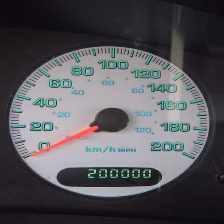

In [72]:
tf.keras.preprocessing.image.array_to_img(image[0])

In [68]:
orig_logist = model(image)
q_logist = q_model(image)
label1 = tf.keras.applications.resnet.decode_predictions(orig_logist.numpy(), top=5)[0][0][1]
label2 = tf.keras.applications.resnet.decode_predictions(q_logist.numpy(), top=5)[0][0][1]

In [69]:
label1

'teddy'

In [70]:
label2

'teddy'